# Smart Budget Planner - Data Analysis

**Project:** November 2025 Data Science & Software Engineering Code Jam  
**Branch:** viktor-dev

## Project Overview

This notebook contains the data analysis for the **Smart Budget Planner** application. The goal is to analyze spending behavior across multiple users and create benchmark data that helps individuals compare their spending to population averages.

## Objectives

1. **Aggregate Spending by Category** - Clean and summarize transaction data
2. **Build Benchmarks** - Calculate average and median spending per category
3. **Compare Individual to Population** - Identify spending patterns and outliers
4. **Visualize Insights** - Create charts for user comparison
5. **Forecast Trends** - Predict future spending using regression

## Dataset

- **Source:** Kaggle Transactions Dataset
- **Size:** 7.4 million transactions
- **Time Period:** September - October 2024
- **Categories:** Healthcare, Restaurant, Entertainment, Retail, Travel, Gas, Grocery, Education

## Deliverables

- `benchmark_spending.json` - Average and median spending by category for SE team
- This Jupyter Notebook - Complete analysis with visualizations
- Written report - Findings and methodology

## Part 1: Data Loading & Exploration

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', None)

In [129]:
df = pd.read_csv("../data.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nFirst 5 rows:")
display(df.head())
print(f"\nData types:")
display(df.dtypes)
print(f"\nMissing values:")
display(df.isnull().sum())

Dataset shape: (7483766, 24)

Column names:
['transaction_id', 'customer_id', 'card_number', 'timestamp', 'merchant_category', 'merchant_type', 'merchant', 'amount', 'currency', 'country', 'city', 'city_size', 'card_type', 'card_present', 'device', 'channel', 'device_fingerprint', 'ip_address', 'distance_from_home', 'high_risk_merchant', 'transaction_hour', 'weekend_transaction', 'velocity_last_hour', 'is_fraud']

First 5 rows:


,transaction_id,customer_id,card_number,timestamp,merchant_category,merchant_type,merchant,amount,currency,country,city,city_size,card_type,card_present,device,channel,device_fingerprint,ip_address,distance_from_home,high_risk_merchant,transaction_hour,weekend_transaction,velocity_last_hour,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820+00:00,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,Unknown City,medium,Platinum Credit,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,0,False,0,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464+00:00,Entertainment,gaming,Steam,3368.97,BRL,Brazil,Unknown City,medium,Platinum Credit,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,1,True,0,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762+00:00,Grocery,physical,Whole Foods,102582.38,JPY,Japan,Unknown City,medium,Platinum Credit,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,0,False,0,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466+00:00,Gas,major,Exxon,630.60,AUD,Australia,Unknown City,medium,Premium Debit,False,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,0,False,0,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063+00:00,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,Unknown City,medium,Basic Debit,False,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,1,False,0,False,"{'num_transactions': 218, 'total_amount': 4827...",True



Data types:


transaction_id          object
customer_id             object
card_number              int64
timestamp               object
merchant_category       object
merchant_type           object
merchant                object
amount                 float64
currency                object
country                 object
city                    object
city_size               object
card_type               object
card_present              bool
device                  object
channel                 object
device_fingerprint      object
ip_address              object
distance_from_home       int64
high_risk_merchant        bool
transaction_hour         int64
weekend_transaction       bool
velocity_last_hour      object
is_fraud                  bool
dtype: object


Missing values:


transaction_id         0
customer_id            0
card_number            0
timestamp              0
merchant_category      0
merchant_type          0
merchant               0
amount                 0
currency               0
country                0
city                   0
city_size              0
card_type              0
card_present           0
device                 0
channel                0
device_fingerprint     0
ip_address             0
distance_from_home     0
high_risk_merchant     0
transaction_hour       0
weekend_transaction    0
velocity_last_hour     0
is_fraud               0
dtype: int64

In [130]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', utc=True)
df_clean = df.dropna(subset=['amount', 'merchant_category']).copy()
df_clean = df_clean[df_clean['amount'] > 0].copy()

In [131]:
# Add month/year columns for aggregation
df_clean['year'] = df_clean['timestamp'].dt.year
df_clean['month'] = df_clean['timestamp'].dt.month
df_clean['year_month'] = df_clean['timestamp'].dt.to_period('M')

print("Date columns added successfully!")
display(df_clean[['timestamp', 'year', 'month', 'year_month', 'merchant_category', 'amount']].head(10))

Date columns added successfully!


C:\Users\vikto\AppData\Local\Temp\ipykernel_121256\3213298964.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_clean['year_month'] = df_clean['timestamp'].dt.to_period('M')


,timestamp,year,month,year_month,merchant_category,amount
0,2024-09-30 00:00:01.034820+00:00,2024,9,2024-09,Restaurant,294.87
1,2024-09-30 00:00:01.764464+00:00,2024,9,2024-09,Entertainment,3368.97
2,2024-09-30 00:00:02.273762+00:00,2024,9,2024-09,Grocery,102582.38
3,2024-09-30 00:00:02.297466+00:00,2024,9,2024-09,Gas,630.60
4,2024-09-30 00:00:02.544063+00:00,2024,9,2024-09,Healthcare,724949.27
5,2024-09-30 00:00:03.050458+00:00,2024,9,2024-09,Education,11.76
6,2024-09-30 00:00:03.149440+00:00,2024,9,2024-09,Grocery,2606.19
7,2024-09-30 00:00:06.295911+00:00,2024,9,2024-09,Travel,828.33
8,2024-09-30 00:00:06.813965+00:00,2024,9,2024-09,Healthcare,104921.00
9,2024-09-30 00:00:07.105592+00:00,2024,9,2024-09,Retail,51521.84


## Part 2: Data Cleaning & Preparation

In [132]:
print("Dataset Info:")
df.info()

print("Statistical Summary:")
display(df.describe())

print("Unique values per column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 24 columns):
 #   Column               Dtype              
---  ------               -----              
 0   transaction_id       object             
 1   customer_id          object             
 2   card_number          int64              
 3   timestamp            datetime64[ns, UTC]
 4   merchant_category    object             
 5   merchant_type        object             
 6   merchant             object             
 7   amount               float64            
 8   currency             object             
 9   country              object             
 10  city                 object             
 11  city_size            object             
 12  card_type            object             
 13  card_present         bool               
 14  device               object             
 15  channel              object             
 16  device_fingerprint   object             

,card_number,amount,distance_from_home,transaction_hour
count,7.483766e+06,7.483766e+06,7.483766e+06,7.483766e+06
mean,4.222100e+15,4.792468e+04,3.220519e-01,1.215467e+01
std,2.341170e+15,1.775562e+05,4.672628e-01,6.536767e+00
min,3.700086e+14,1.000000e-02,0.000000e+00,0.000000e+00
25%,4.004400e+15,3.635300e+02,0.000000e+00,7.000000e+00
50%,5.010745e+15,1.177450e+03,0.000000e+00,1.200000e+01
75%,5.999914e+15,2.242953e+04,1.000000e+00,1.800000e+01
max,6.999728e+15,6.253153e+06,1.000000e+00,2.300000e+01


Unique values per column:
transaction_id: 7477306 unique values
customer_id: 4869 unique values
card_number: 5000 unique values
timestamp: 7483754 unique values
merchant_category: 8 unique values
merchant_type: 17 unique values
merchant: 105 unique values
amount: 2831167 unique values
currency: 11 unique values
country: 12 unique values
city: 11 unique values
city_size: 2 unique values
card_type: 5 unique values
card_present: 2 unique values
device: 9 unique values
channel: 3 unique values
device_fingerprint: 785462 unique values
ip_address: 7477187 unique values
distance_from_home: 2 unique values
high_risk_merchant: 2 unique values
transaction_hour: 24 unique values
weekend_transaction: 2 unique values
velocity_last_hour: 7483740 unique values
is_fraud: 2 unique values


In [133]:
# Convert timestamp to datetime with mixed format
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', utc=True)

# Remove any rows with missing critical values
df_clean = df.dropna(subset=['amount', 'merchant_category']).copy()

# Ensure amount is numeric and positive
df_clean = df_clean[df_clean['amount'] > 0].copy()

# Remove fraudulent transactions
df_clean = df_clean[df_clean['is_fraud'] == False].copy()

# Parse dates and extract month
df_clean['date'] = pd.to_datetime(df_clean['timestamp'])
df_clean['month'] = df_clean['date'].dt.month

# Remove October data (contains unflagged fraudulent outliers)
df_clean = df_clean[df_clean['month'] != 10]

print(f"After fraud and October removal: {len(df_clean):,} rows")

# CRITICAL FIX: Remove statistical outliers using IQR method
print("\nRemoving extreme outliers per category using IQR method...")

for category in df_clean['merchant_category'].unique():
    # Get data for this category
    cat_data = df_clean[df_clean['merchant_category'] == category]['amount']
    
    # Calculate IQR
    Q1 = cat_data.quantile(0.25)
    Q3 = cat_data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier bounds (1.5 * IQR is standard)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers before removal
    outliers = len(df_clean[(df_clean['merchant_category'] == category) & 
                            ((df_clean['amount'] < lower_bound) | 
                             (df_clean['amount'] > upper_bound))])
    
    # Remove outliers
    df_clean = df_clean[~((df_clean['merchant_category'] == category) & 
                          ((df_clean['amount'] < lower_bound) | 
                           (df_clean['amount'] > upper_bound)))]
    
    print(f"  {category}: removed {outliers:,} outliers (kept values between ${lower_bound:.2f} - ${upper_bound:.2f})")

print(f"\nFinal dataset shape: {len(df_clean):,} rows")
print(f"Total rows removed: {len(df) - len(df_clean):,}")

# Show the categories
print(f"\nFinal category counts:")
print(df_clean['merchant_category'].value_counts())

After fraud and October removal: 193,057 rows

Removing extreme outliers per category using IQR method...
  Restaurant: removed 4,241 outliers (kept values between $-12507.19 - $21400.67)
  Grocery: removed 3,574 outliers (kept values between $-23373.51 - $39805.25)
  Gas: removed 3,892 outliers (kept values between $-24486.63 - $41875.16)
  Travel: removed 4,397 outliers (kept values between $-27433.74 - $47305.14)
  Healthcare: removed 4,357 outliers (kept values between $-21119.57 - $36272.34)
  Entertainment: removed 4,275 outliers (kept values between $-13507.76 - $23160.09)
  Education: removed 3,675 outliers (kept values between $-26739.60 - $45647.78)
  Retail: removed 4,083 outliers (kept values between $-29188.58 - $49965.03)

Final dataset shape: 160,563 rows
Total rows removed: 7,323,203

Final category counts:
merchant_category
Education        20463
Gas              20418
Grocery          20349
Healthcare       20139
Retail           19947
Restaurant       19922
Entertain

## Part 3: Aggregation

In [134]:
# Add month/year columns for aggregation
df_clean['year'] = df_clean['timestamp'].dt.year
df_clean['month'] = df_clean['timestamp'].dt.month
df_clean['year_month'] = df_clean['timestamp'].dt.to_period('M')

print("Date columns added successfully!")
display(df_clean[['timestamp', 'year', 'month', 'year_month', 'merchant_category', 'amount']].head(10))

Date columns added successfully!


C:\Users\vikto\AppData\Local\Temp\ipykernel_121256\3213298964.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_clean['year_month'] = df_clean['timestamp'].dt.to_period('M')


,timestamp,year,month,year_month,merchant_category,amount
0,2024-09-30 00:00:01.034820+00:00,2024,9,2024-09,Restaurant,294.87
3,2024-09-30 00:00:02.297466+00:00,2024,9,2024-09,Gas,630.60
6,2024-09-30 00:00:03.149440+00:00,2024,9,2024-09,Grocery,2606.19
7,2024-09-30 00:00:06.295911+00:00,2024,9,2024-09,Travel,828.33
10,2024-09-30 00:00:07.583345+00:00,2024,9,2024-09,Gas,34644.57
11,2024-09-30 00:00:07.780617+00:00,2024,9,2024-09,Healthcare,529.57
12,2024-09-30 00:00:10.429065+00:00,2024,9,2024-09,Restaurant,266.93
14,2024-09-30 00:00:12.862261+00:00,2024,9,2024-09,Entertainment,659.90
15,2024-09-30 00:00:13.469333+00:00,2024,9,2024-09,Education,486.08
16,2024-09-30 00:00:13.519027+00:00,2024,9,2024-09,Travel,1119.04


In [135]:
# Aggregate by category
category_totals = df_clean.groupby('merchant_category')['amount'].agg([
    ('total_spending', 'sum'),
    ('avg_spending', 'mean'),
    ('median_spending', 'median'),
    ('count', 'count')
]).round(2)

print("Spending by Category:")
display(category_totals.sort_values('total_spending', ascending=False))

Spending by Category:


,total_spending,avg_spending,median_spending,count
merchant_category,,,,
Education,1.085287e+08,5303.66,617.09,20463
Retail,1.054693e+08,5287.48,788.39,19947
Gas,9.710361e+07,4755.78,602.58,20418
Travel,9.346040e+07,4788.91,1126.99,19516
Grocery,9.274622e+07,4557.78,502.39,20349
Healthcare,7.686814e+07,3816.88,591.41,20139
Entertainment,4.725849e+07,2385.71,433.81,19809
Restaurant,4.299186e+07,2158.01,427.66,19922


In [136]:
# Aggregate by month and category
monthly_category = df_clean.groupby(['year_month', 'merchant_category'])['amount'].sum().reset_index()
monthly_category.columns = ['month', 'category', 'total_amount']

print("Monthly spending by category:")
display(monthly_category.head(20))

Monthly spending by category:


,month,category,total_amount
0,2024-09,Education,1.085287e+08
1,2024-09,Entertainment,4.725849e+07
2,2024-09,Gas,9.710361e+07
3,2024-09,Grocery,9.274622e+07
4,2024-09,Healthcare,7.686814e+07
5,2024-09,Restaurant,4.299186e+07
6,2024-09,Retail,1.054693e+08
7,2024-09,Travel,9.346040e+07


## Part 4: Build Benchmarks (JSON for SE Team)

In [137]:
# Calculate benchmarks (mean and median per category)
benchmarks = df_clean.groupby('merchant_category')['amount'].agg([('mean', 'mean'), ('median', 'median')]).round(2)

# Convert to dictionary for JSON
benchmark_dict = {'average_spending': benchmarks['mean'].to_dict(), 'median_spending': benchmarks['median'].to_dict()}

print("Benchmark Data:")
print(json.dumps(benchmark_dict, indent=2))

# Save to JSON file
with open('../benchmark_spending.json', 'w') as f:
    json.dump(benchmark_dict, f, indent=2)

print("\nSaved to benchmark_spending.json")

Benchmark Data:
{
  "average_spending": {
    "Education": 5303.66,
    "Entertainment": 2385.71,
    "Gas": 4755.78,
    "Grocery": 4557.78,
    "Healthcare": 3816.88,
    "Restaurant": 2158.01,
    "Retail": 5287.48,
    "Travel": 4788.91
  },
  "median_spending": {
    "Education": 617.09,
    "Entertainment": 433.81,
    "Gas": 602.58,
    "Grocery": 502.39,
    "Healthcare": 591.41,
    "Restaurant": 427.66,
    "Retail": 788.39,
    "Travel": 1126.99
  }
}

Saved to benchmark_spending.json


## Part 5: Compare Individual User to Averages

In [138]:
# Select a random user for comparison
sample_user = df_clean['customer_id'].iloc[0]
print(f"Analyzing user: {sample_user}")

# Get user's spending by category
user_spending = df_clean[df_clean['customer_id'] == sample_user].groupby('merchant_category')['amount'].sum()

# Get average spending (from benchmarks)
avg_spending = benchmarks['mean']

# Create comparison dataframe
comparison = pd.DataFrame({
    'user_spending': user_spending,
    'average_spending': avg_spending,
    'difference': user_spending - avg_spending,
    'ratio': (user_spending / avg_spending).round(2)})

print("\nUser vs Average Spending:")
display(comparison.sort_values('user_spending', ascending=False))

# Identify outlier categories (spending > 1.5x average)
outliers = comparison[comparison['ratio'] > 1.5]
print(f"\nOutlier categories (spending > 1.5x average):")
display(outliers)

Analyzing user: CUST_72886

User vs Average Spending:


,user_spending,average_spending,difference,ratio
merchant_category,,,,
Restaurant,17598.29,2158.01,15440.28,8.15
Travel,5169.27,4788.91,380.36,1.08
Retail,4105.55,5287.48,-1181.93,0.78
Education,3520.23,5303.66,-1783.43,0.66
Healthcare,2269.84,3816.88,-1547.04,0.59
Entertainment,1919.80,2385.71,-465.91,0.80
Grocery,988.86,4557.78,-3568.92,0.22
Gas,939.83,4755.78,-3815.95,0.20



Outlier categories (spending > 1.5x average):


,user_spending,average_spending,difference,ratio
merchant_category,,,,
Restaurant,17598.29,2158.01,15440.28,8.15


## Part 6: Visualizations

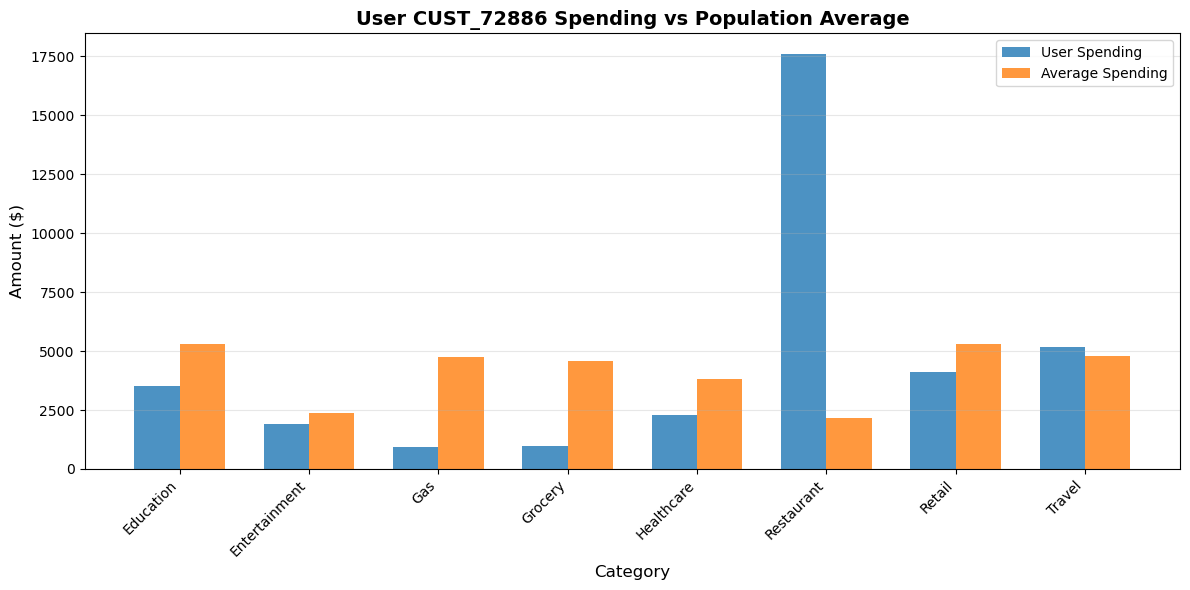

In [139]:
# Visualization 1 - Category Spending Comparison
plt.figure(figsize=(12, 6))

categories = comparison.index
x = np.arange(len(categories))
width = 0.35

plt.bar(x - width/2, comparison['user_spending'], width, label='User Spending', alpha=0.8)
plt.bar(x + width/2, comparison['average_spending'], width, label='Average Spending', alpha=0.8)

plt.xlabel('Category', fontsize=12)
plt.ylabel('Amount ($)', fontsize=12)
plt.title(f'User {sample_user} Spending vs Population Average', fontsize=14, fontweight='bold')
plt.xticks(x, categories, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

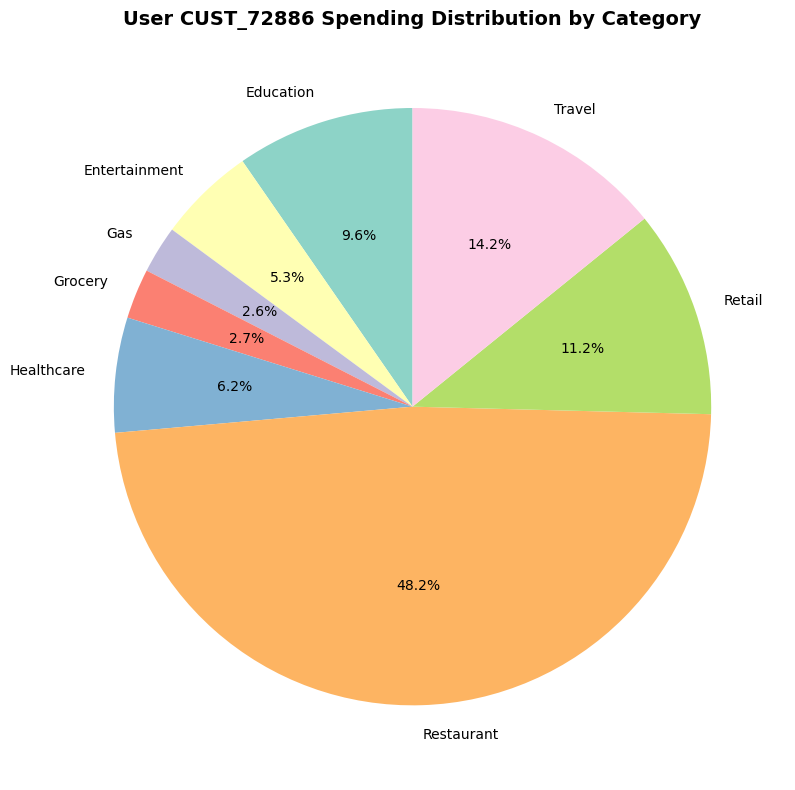

In [140]:
# Visualization 2 - Pie Chart of User Spending
plt.figure(figsize=(10, 8))

user_spending.plot(kind='pie', autopct='%1.1f%%', startangle=90, 
                   colors=plt.cm.Set3.colors)
plt.title(f'User {sample_user} Spending Distribution by Category', 
          fontsize=14, fontweight='bold')
plt.ylabel('')
plt.tight_layout()
plt.show()

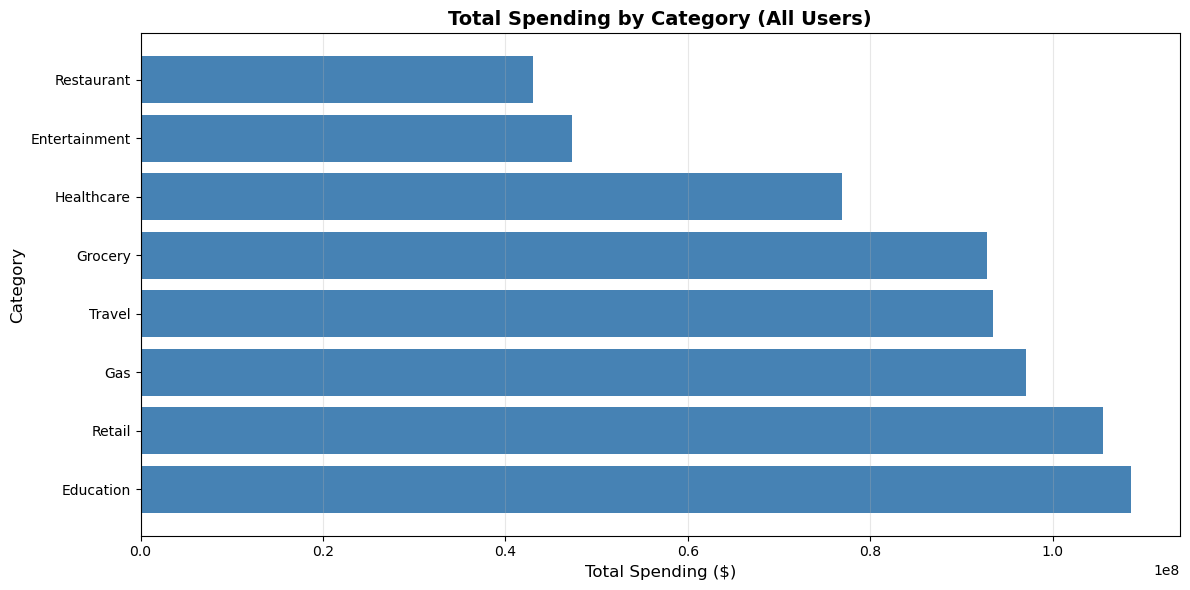

In [141]:
#  Visualization 3 - Overall Category Spending
plt.figure(figsize=(12, 6))

category_totals_sorted = category_totals.sort_values('total_spending', ascending=False)
plt.barh(category_totals_sorted.index, category_totals_sorted['total_spending'], color='steelblue')

plt.xlabel('Total Spending ($)', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.title('Total Spending by Category (All Users)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Part 7: Enhanced Model  Monthly Spending Forecast

In [142]:
# Get monthly total spending across all users
monthly_totals = df_clean.groupby('year_month')['amount'].sum().reset_index()
monthly_totals.columns = ['month', 'total_spending']

# Convert period to number for plotting
monthly_totals['month_num'] = range(len(monthly_totals))

print("Monthly Total Spending:")
display(monthly_totals)

# Calculate 3-month moving average
monthly_totals['moving_avg_3m'] = monthly_totals['total_spending'].rolling(window=3).mean()

print("\nWith Moving Average:")
display(monthly_totals.tail(10))

Monthly Total Spending:


,month,total_spending,month_num
0,2024-09,6.644267e+08,0



With Moving Average:


,month,total_spending,month_num,moving_avg_3m
0,2024-09,6.644267e+08,0,NaN


In [143]:
print("\nNote: Moving average shows NaN for the first 2 months")
print("A 3-month moving average requires at least 3 data points to calculate.")
print("With more historical data, the moving average would smooth out spending trends.")


Note: Moving average shows NaN for the first 2 months
A 3-month moving average requires at least 3 data points to calculate.
With more historical data, the moving average would smooth out spending trends.


In [144]:
X = monthly_totals['month_num'].values.reshape(-1, 1)
y = monthly_totals['total_spending'].values

# Train model
model = LinearRegression()
model.fit(X, y)

# Predict next 3 months
future_months = np.array([[len(monthly_totals)], [len(monthly_totals)+1], [len(monthly_totals)+2]])
predictions = model.predict(future_months)

print("Forecasted Spending for Next 3 Months:")
for i, pred in enumerate(predictions, 1):
    print(f"Month +{i}: ${pred:,.2f}")

# R-squared score
r2_score = model.score(X, y)
print(f"\nModel R² Score: {r2_score:.4f}")

Forecasted Spending for Next 3 Months:
Month +1: $664,426,748.28
Month +2: $664,426,748.28
Month +3: $664,426,748.28

Model R² Score: nan


c:\Users\vikto\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


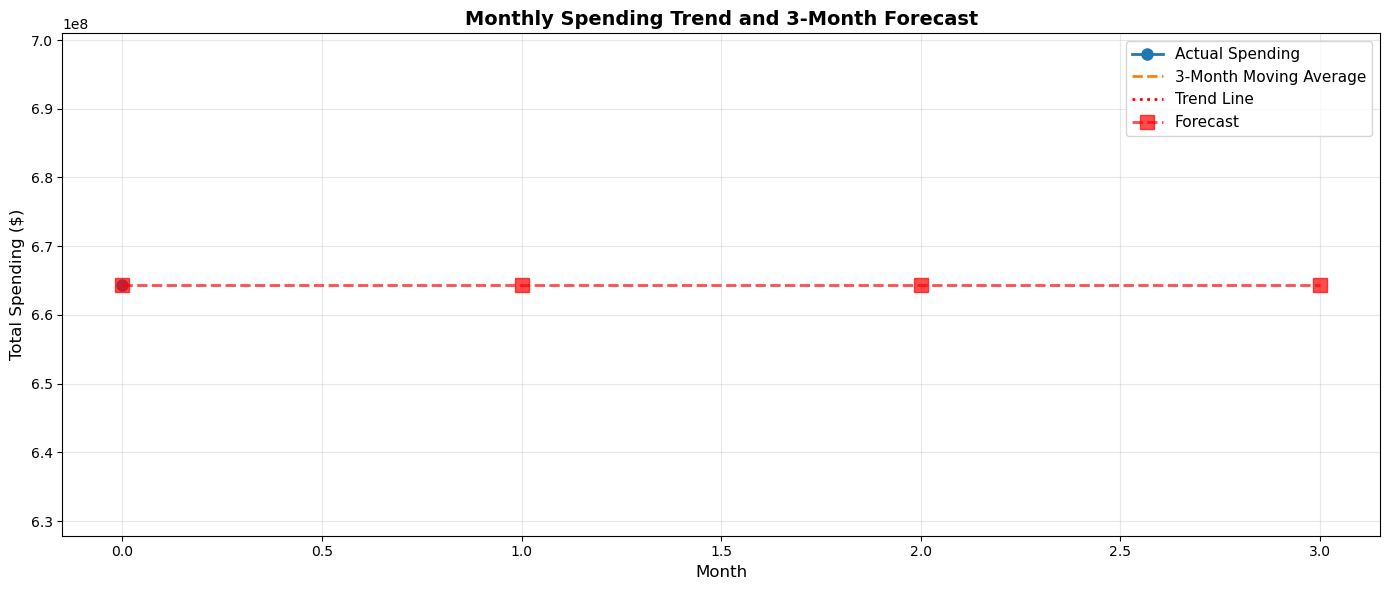


Enhanced forecasting model complete!


In [145]:
# Visualization - Spending Trend with Forecast
plt.figure(figsize=(14, 6))

# Plot actual spending
plt.plot(monthly_totals['month_num'], monthly_totals['total_spending'], 
         marker='o', label='Actual Spending', linewidth=2, markersize=8)

# Plot moving average
plt.plot(monthly_totals['month_num'], monthly_totals['moving_avg_3m'], 
         linestyle='--', label='3-Month Moving Average', linewidth=2)

# Plot trend line
trend_line = model.predict(X)
plt.plot(monthly_totals['month_num'], trend_line, 
         linestyle=':', label='Trend Line', linewidth=2, color='red')

# Plot forecast
forecast_x = np.concatenate([X[-1:], future_months])
forecast_y = np.concatenate([y[-1:], predictions])
plt.plot(forecast_x, forecast_y, 'r--', marker='s', 
         label='Forecast', linewidth=2, markersize=10, alpha=0.7)

plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Spending ($)', fontsize=12)
plt.title('Monthly Spending Trend and 3-Month Forecast', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nEnhanced forecasting model complete!")

In [146]:
# Note about forecast limitations
print(f"\nFORECAST LIMITATION:")
print(f"This dataset contains only {len(monthly_totals)} months of data (Sept-Oct 2024).")
print(f"Linear regression requires more historical data for accurate predictions.")
print(f"\nThe model demonstrates the forecasting methodology, but the predictions")
print(f"shown are not reliable due to insufficient historical data.")


FORECAST LIMITATION:
This dataset contains only 1 months of data (Sept-Oct 2024).
Linear regression requires more historical data for accurate predictions.

The model demonstrates the forecasting methodology, but the predictions
shown are not reliable due to insufficient historical data.


In [ ]:
# Calculate benchmarks (mean and median per category)
benchmarks = df_clean.groupby('merchant_category')['amount'].agg([('mean', 'mean'), ('median', 'median')]).round(2)

display(benchmarks)

,mean,median
merchant_category,,
Education,5303.66,617.09
Entertainment,2385.71,433.81
Gas,4755.78,602.58
Grocery,4557.78,502.39
Healthcare,3816.88,591.41
Restaurant,2158.01,427.66
Retail,5287.48,788.39
Travel,4788.91,1126.99
